In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import model_selection, preprocessing,linear_model, metrics, pipeline

plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = [10.0, 6.0]

%matplotlib inline

In [24]:
train = pd.read_csv('../../data/titanic/train.csv')
test = pd.read_csv('../../data/titanic/test.csv')

In [25]:
train['Pclass'] = train['Pclass'].astype('object')

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null object
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(6)
memory usage: 83.6+ KB


In [28]:
medians = train.dropna().groupby('Sex')['Age'].median()
for i in train[train['Age'].isnull()].index:
    train.loc[i,'Age'] = medians[train.loc[i,'Sex']]

In [29]:
target = 'Survived'
features = list(train.columns)
features.remove('PassengerId')
features.remove('Name')
features.remove('Cabin')
features.remove('Ticket')
features.remove(target)
features , target

(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], 'Survived')

In [30]:
X = train.loc[:,features]
y = train.loc[:,target]
X.shape,y.shape

((891, 7), (891,))

In [33]:
X.head()

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,22.0,1,0,7.2500,0,1,1,0,1
1,38.0,1,0,71.2833,0,0,0,0,0
2,26.0,0,0,7.9250,0,1,0,0,1
3,35.0,1,0,53.1000,0,0,0,0,1
4,35.0,0,0,8.0500,0,1,1,0,1


In [32]:
X = pd.get_dummies(X, drop_first= True)
X.shape

(891, 9)

In [38]:
X_train, X_test, y_train,y_test = model_selection.train_test_split(X,y, test_size = 0.3, random_state = 1)

In [50]:
# lr = linear_model.LogisticRegression(penalty='l2',random_state=1)
# lr.fit(X_train, y_train)
est = pipeline.Pipeline([
    #("poly", preprocessing.PolynomialFeatures(degree=1, include_bias=False)),
    ("scaler", preprocessing.StandardScaler()),
    ("lr", linear_model.LogisticRegression(random_state=1,penalty='l1'))
])
est.fit(X_train,y_train)

y_train_pred = est.predict(X_train)
y_test_pred = est.predict(X_test)

# outcome = pd.DataFrame({"actual": y_test,"pred": y_test_pred}) 
# outcome["match"] = outcome.actual == outcome.pred
# outcome.sample(10)


print("[Train] Accuracy :: %.3f" % metrics.accuracy_score(y_true=y_train,y_pred=y_train_pred))
print("[Train] Precision :: %.3f" % metrics.precision_score(y_true=y_train,y_pred=y_train_pred))
print("[Train] Recall :: %.3f" % metrics.recall_score(y_true=y_train,y_pred=y_train_pred))

print("----------------------")

print("[Test] Accuracy :: %.3f" % metrics.accuracy_score(y_true=y_test,y_pred=y_test_pred))
print("[Test] Precision :: %.3f" % metrics.precision_score(y_true=y_test,y_pred=y_test_pred))
print("[Test] Recall :: %.3f" % metrics.recall_score(y_true=y_test,y_pred=y_test_pred))

[Train] Accuracy :: 0.819
[Train] Precision :: 0.777
[Train] Recall :: 0.705
----------------------
[Test] Accuracy :: 0.784
[Test] Precision :: 0.782
[Test] Recall :: 0.687


In [54]:
y_test_prob = est.predict_proba(X_test)[:,1]

In [40]:
confusion_matrix = metrics.confusion_matrix(y_true=y_test,y_pred=y_test_pred)
confusion_matrix

array([[136,  17],
       [ 39,  76]], dtype=int64)

Text(0.5,1,'ROC, auc: 0.825263')

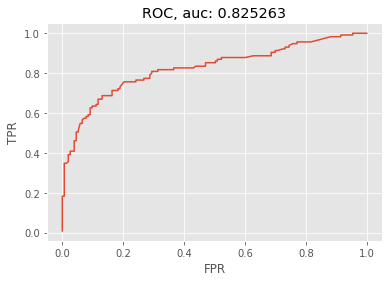

In [55]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_test_prob)

plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC, auc: %f" % (metrics.auc(fpr, tpr)))

array([0.97549737, 0.92570927, 0.92264539, 0.88279041, 0.87953212,
       0.83698621, 0.82233793, 0.81789851, 0.81786976, 0.81429058,
       0.79999516, 0.79621158, 0.79083726, 0.7866431 , 0.75303178,
       0.7494829 , 0.68208598, 0.67973127, 0.67043542, 0.66637773,
       0.66229147, 0.65260458, 0.6427897 , 0.63488276, 0.63285353,
       0.63249316, 0.60661575, 0.60543455, 0.58915093, 0.58232945,
       0.57806551, 0.55309976, 0.54992301, 0.5456019 , 0.54241595,
       0.54217033, 0.53172177, 0.51346461, 0.46901231, 0.46363589,
       0.46045308, 0.40063085, 0.39315018, 0.38706167, 0.3799331 ,
       0.36985311, 0.36686031, 0.35293818, 0.33115307, 0.31847608,
       0.30550412, 0.30282257, 0.29768938, 0.29665609, 0.293807  ,
       0.29321046, 0.28936442, 0.28756237, 0.24882245, 0.23539954,
       0.20582728, 0.20375456, 0.18556113, 0.17324212, 0.14647621,
       0.13780542, 0.13750676, 0.13278044, 0.12762467, 0.12624565,
       0.10293514, 0.10167759, 0.09408459, 0.09290345, 0.09226